# A Comparative study on Restaurant Reviews Classification

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import os

c:\users\avigy\appdata\local\programs\python\python39\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
reviews = pd.read_csv("Restaurant_Reviews.csv")
reviews.head(10)

,Review,Liked
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1
5,Now I am getting angry and I want my damn pho.,0
6,Honeslty it didn't taste THAT fresh.),0
7,The potatoes were like rubber and you could te...,0
8,The fries were great too.,1
9,A great touch.,1


### Counting the values of positive vs negative reviews

In [3]:
liked_counts = reviews['Liked'].value_counts()
print(liked_counts)

1    500
0    500
Name: Liked, dtype: int64


### Performing text mining operations to prepare the data for classification

In [4]:
# Necessary libraries
from sklearn.model_selection import train_test_split
from sklearn import metrics

import re
import string

from tensorflow import keras
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import SimpleRNN, LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [5]:
def strip_emoji(text):
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese characters
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

#Remove punctuations, links, mentions and \r\n new line characters
def strip_all_entities(text):
    text = text.replace('\r', '').replace('\n', ' ').replace('\n', ' ').lower() #remove \n and \r and lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) #remove links and mentions
    text = re.sub(r'[^\x00-\x7f]',r'', text) #remove non utf8/ascii characters such as '\x9a\x91\x97\x9a\x97'
    banned_list= string.punctuation + 'Ã'+'±'+'ã'+'¼'+'â'+'»'+'§'
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    return text

#clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the # symbol
def clean_hashtags(text):
    new_text = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', text)) #remove last hashtags
    new_text2 = " ".join(word.strip() for word in re.split('#|_', new_text)) #remove hashtags symbol from words in the middle of the sentence
    return new_text2

#Filter special characters such as & and $ present in some words
def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

def remove_mult_spaces(text): # remove multiple spaces
    return re.sub("\s\s+" , " ", text)

In [6]:
reviews['cleaned_reviews'] = (reviews['Review']
                     .apply(strip_emoji)
                     .apply(strip_all_entities)
                     .apply(clean_hashtags)
                     .apply(filter_chars)
                     .apply(remove_mult_spaces))
reviews.head()

,Review,Liked,cleaned_reviews
0,Wow... Loved this place.,1,wow loved this place
1,Crust is not good.,0,crust is not good
2,Not tasty and the texture was just nasty.,0,not tasty and the texture was just nasty
3,Stopped by during the late May bank holiday of...,1,stopped by during the late may bank holiday of...
4,The selection on the menu was great and so wer...,1,the selection on the menu was great and so wer...


Before using any ML algorithm, let us see how sentiment analysis tools such as vaderSentiment can correctly identify negative and positive reviews left by patrons.

In [7]:
pip install vaderSentiment

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\users\avigy\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


In [8]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Select the first three positive and negative reviews
positive_reviews = reviews[reviews['Liked'] == 1]['cleaned_reviews'][:3].tolist()
negative_reviews = reviews[reviews['Liked'] == 0]['cleaned_reviews'][:3].tolist()

# Combine the positive and negative reviews
all_reviews = positive_reviews + negative_reviews

# Initialize the sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Analyze sentiment for each review
results = []
for review in all_reviews:
    sentiment = analyzer.polarity_scores(review)
    sentiment_score = sentiment['compound']
    sentiment_label = "this is a positive review" if sentiment_score >= 0 else "this is a negative review"
    results.append({
        "Review": review,
        "Sentiment Score": sentiment_score,
        "Sentiment Label": sentiment_label
    })

# Create a DataFrame to display the results
output_table = pd.DataFrame(results)

# Print the output table
print(output_table)

                                              Review  Sentiment Score  \
0                               wow loved this place           0.8271   
1  stopped by during the late may bank holiday of...           0.6908   
2  the selection on the menu was great and so wer...           0.6249   
3                                  crust is not good          -0.3412   
4           not tasty and the texture was just nasty          -0.5574   
5      now i am getting angry and i want my damn pho          -0.6908   

             Sentiment Label  
0  this is a positive review  
1  this is a positive review  
2  this is a positive review  
3  this is a negative review  
4  this is a negative review  
5  this is a negative review  


#### Calculating sentiment scores for each review

In [9]:
# Initialize the sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Calculate sentiment scores for each review
reviews['Sentiment Score'] = reviews['cleaned_reviews'].apply(lambda review: analyzer.polarity_scores(review)['compound'])

# Count positive and negative reviews
positive_reviews_count = reviews[reviews['Sentiment Score'] >= 0].shape[0]
negative_reviews_count = reviews[reviews['Sentiment Score'] < 0].shape[0]

reviews.head()

,Review,Liked,cleaned_reviews,Sentiment Score
0,Wow... Loved this place.,1,wow loved this place,0.8271
1,Crust is not good.,0,crust is not good,-0.3412
2,Not tasty and the texture was just nasty.,0,not tasty and the texture was just nasty,-0.5574
3,Stopped by during the late May bank holiday of...,1,stopped by during the late may bank holiday of...,0.6908
4,The selection on the menu was great and so wer...,1,the selection on the menu was great and so wer...,0.6249


In [10]:
# Print the counts
print("Number of Positive Reviews:", positive_reviews_count)
print("Number of Negative Reviews:", negative_reviews_count)

Number of Positive Reviews: 735
Number of Negative Reviews: 265


Well, this is not good performance. I guess we have to go the machine learning route to get some better performance. VADER, while a valuable tool for sentiment analysis, operates on a lexicon-based approach that assigns a polarity score to each word in a given text and then computes an overall sentiment score based on these scores. This method has its strengths, particularly in capturing the sentiment of individual words, idioms, and expressions. However, it also has limitations.

## Classifying reviews using a random forest classifier

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Split the data into training and testing sets
X = reviews['cleaned_reviews']
y = reviews['Liked']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature extraction (TF-IDF or CountVectorizer can be used)
vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Train the Random Forest classifier
classifier = RandomForestClassifier(random_state=42)
classifier.fit(X_train_vec, y_train)

RandomForestClassifier(random_state=42)

In [12]:
# Make predictions
y_pred = classifier.predict(X_test_vec)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.76
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.82      0.77        96
           1       0.81      0.70      0.75       104

    accuracy                           0.76       200
   macro avg       0.76      0.76      0.76       200
weighted avg       0.77      0.76      0.76       200

Confusion Matrix:
[[79 17]
 [31 73]]


<AxesSubplot:>

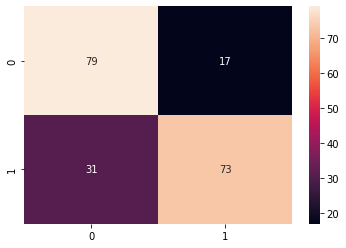

In [13]:
sns.heatmap(confusion_matrix(y_test, y_pred),annot=True)

#### Let's see if tuning the randomforest hyperparameters can get us better performance:

In [14]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid to search
param_grid = {
    'n_estimators': [50, 100, 200],           # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],           # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],           # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]              # Minimum number of samples required to be at a leaf node
}

# Create the Random Forest classifier
classifier = RandomForestClassifier(random_state=142)

# Create the GridSearchCV instance
grid_search = GridSearchCV(classifier, param_grid, cv=5, scoring='accuracy')

# Fit the GridSearchCV instance to the data
grid_search.fit(X_train_vec, y_train)

# Print the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
Best Score: 0.8099999999999999


#### Fitting the random forest with optimal hyperparameters:

In [15]:
# Best parameters from grid search
best_params = {
    'min_samples_leaf': 1,
    'max_depth': None,
    'min_samples_split': 5,
    'n_estimators': 50
}

# Create the Random Forest classifier with the best parameters
best_classifier = RandomForestClassifier(**best_params, random_state=142)

# Train the classifier
best_classifier.fit(X_train_vec, y_train)

# Make predictions
y_pred = best_classifier.predict(X_test_vec)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.77
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.81      0.77        96
           1       0.81      0.73      0.77       104

    accuracy                           0.77       200
   macro avg       0.77      0.77      0.77       200
weighted avg       0.77      0.77      0.77       200

Confusion Matrix:
[[78 18]
 [28 76]]


We got a 1% performance improvement from hyperparameter tuning

<AxesSubplot:>

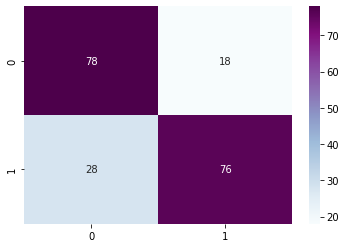

In [16]:
sns.heatmap(confusion_matrix(y_test, y_pred),cmap="BuPu",annot=True)

## Classifying reviews using a Naive-Bayes classifier 

#### Multinomial NB:-

In [17]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Create the Naive Bayes classifier
naive_bayes_classifier = MultinomialNB()

# Train the classifier
naive_bayes_classifier.fit(X_train_vec, y_train)

# Make predictions
y_pred_nb = naive_bayes_classifier.predict(X_test_vec)

# Evaluate the classifier
accuracy_nb = accuracy_score(y_test, y_pred_nb)
print(f"Multinomial Naive Bayes Accuracy: {accuracy_nb:.2f}")

print("Multinomial Naive Bayes Classification Report:")
print(classification_report(y_test, y_pred_nb))

print("Multinomial Naive Bayes Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_nb))

Multinomial Naive Bayes Accuracy: 0.78
Multinomial Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.83      0.78        96
           1       0.83      0.73      0.78       104

    accuracy                           0.78       200
   macro avg       0.78      0.78      0.78       200
weighted avg       0.79      0.78      0.78       200

Multinomial Naive Bayes Confusion Matrix:
[[80 16]
 [28 76]]


<AxesSubplot:>

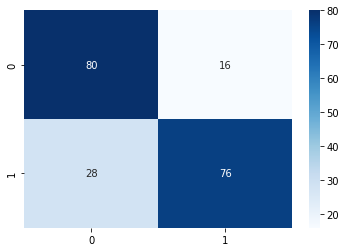

In [18]:
sns.heatmap(confusion_matrix(y_test, y_pred_nb),cmap="Blues",annot=True)

#### Gaussian NB:-

In [19]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer

# Create the Naive Bayes classifier
gaussian_naive_bayes_classifier = GaussianNB()
X_train_vec2 = X_train_vec.toarray()
X_test_vec2 = X_test_vec.toarray()

# Train the classifier
gaussian_naive_bayes_classifier.fit(X_train_vec2, y_train)

# Make predictions
y_pred_gnb = gaussian_naive_bayes_classifier.predict(X_test_vec2)

# Evaluate the classifier
accuracy_gnb = accuracy_score(y_test, y_pred_gnb)
print(f"Gaussian Naive Bayes Accuracy: {accuracy_gnb:.2f}")

print("Gaussian Naive Bayes Classification Report:")
print(classification_report(y_test, y_pred_gnb))

print("Gaussian Naive Bayes Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_gnb))

Gaussian Naive Bayes Accuracy: 0.71
Gaussian Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.55      0.65        96
           1       0.67      0.86      0.75       104

    accuracy                           0.71       200
   macro avg       0.73      0.70      0.70       200
weighted avg       0.72      0.71      0.70       200

Gaussian Naive Bayes Confusion Matrix:
[[53 43]
 [15 89]]


<AxesSubplot:>

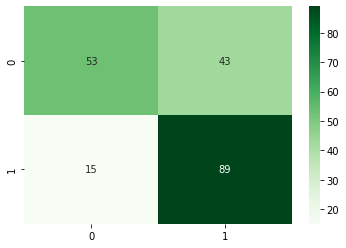

In [20]:
sns.heatmap(confusion_matrix(y_test, y_pred_gnb),cmap="Greens",annot=True)

## Classifying reviews using a Logistic Regression model

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Create the Logistic Regressor
log_model = LogisticRegression()

# Train the classifier
log_model.fit(X_train_vec, y_train)

# Make predictions
y_pred_lr = log_model.predict(X_test_vec)

# Evaluate the classifier
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print(f"Logistic Regression Accuracy: {accuracy_lr:.2f}")

print("Logistic Regression Report:")
print(classification_report(y_test, y_pred_lr))

print("Logistic Regression Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_lr))

Logistic Regression Accuracy: 0.81
Logistic Regression Report:
              precision    recall  f1-score   support

           0       0.76      0.89      0.82        96
           1       0.88      0.74      0.80       104

    accuracy                           0.81       200
   macro avg       0.82      0.81      0.81       200
weighted avg       0.82      0.81      0.81       200

Logistic Regression Confusion Matrix:
[[85 11]
 [27 77]]


<AxesSubplot:>

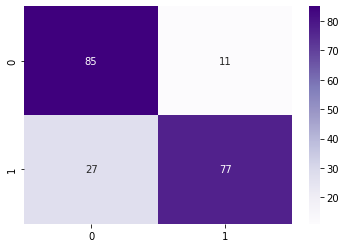

In [22]:
sns.heatmap(confusion_matrix(y_test, y_pred_lr),cmap="Purples",annot=True)

## Classifying restaurant reviews using Support Vector Machines

Hyperparameter tuning of the radial based kernel SVM

In [23]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Define the parameter grid to search
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': [0.1, 1, 'scale', 'auto'],
    'kernel': ['rbf']
}

# Create the SVM classifier
svm_classifier = SVC()

# Create the GridSearchCV instance
grid_search_svm = GridSearchCV(svm_classifier, param_grid, cv=5, scoring='accuracy')

# Fit the GridSearchCV instance to the data
grid_search_svm.fit(X_train_vec, y_train)

# Print the best parameters and best score
print("Best Parameters for SVM:", grid_search_svm.best_params_)
print("Best Score for SVM:", grid_search_svm.best_score_)

Best Parameters for SVM: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best Score for SVM: 0.7975000000000001


Model fitting using optimal hyperparameters:

In [24]:
# Create the SVM classifier with the best parameters
best_svm_classifier = SVC(**grid_search_svm.best_params_)

# Train the classifier
best_svm_classifier.fit(X_train_vec, y_train)

# Make predictions
y_pred_svm = best_svm_classifier.predict(X_test_vec)

# Evaluate the classifier
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f"SVM Accuracy: {accuracy_svm:.2f}")

print("SVM Classification Report:")
print(classification_report(y_test, y_pred_svm))

print("SVM Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_svm))

SVM Accuracy: 0.78
SVM Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.83      0.78        96
           1       0.82      0.72      0.77       104

    accuracy                           0.78       200
   macro avg       0.78      0.78      0.77       200
weighted avg       0.78      0.78      0.77       200

SVM Confusion Matrix:
[[80 16]
 [29 75]]


<AxesSubplot:>

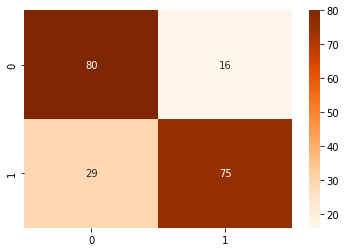

In [25]:
sns.heatmap(confusion_matrix(y_test, y_pred_svm),cmap="Oranges",annot=True)

Accuracies of different algorithms:-
* Random Forest = 77% (76% without hyperparameter turing)
* Naive Bayes = 78% (Multinomial); 71% (Gaussian)
* Logistic Regression = 81%
* SVM = 78%

Thus, from the above data, we can say that Logistic Regression is performing the best.

Difference between performance of ML algorithms and VADER sentiment scores: 

While machine learning algorithms consider the entire context and relationships between words in a review, VADER operates on a word-by-word basis. Therefore, the differences in results highlight the complexity of accurately assessing sentiment using automated methods and the necessity of combining such methods with more advanced techniques, such as machine learning algorithms, to achieve accurate and reliable sentiment classification.